# DeepUnfolding ADMM as a generalization of learned optimization

In [1]:
import numpy as np

from matplotlib import pyplot as plt

### Implementing standard ADMM procedure

In [2]:
def softshrink(x, lambda_):
    return np.sign(x) * np.maximum(0, np.abs(x) - lambda_)

In [3]:
def ADMM(A, y, rho = 10, lambda_ = 0.1, mu = 0.00005, max_iter = 200):

    # Inital values

    z = np.zeros(A.shape[1])
    u = np.zeros(A.shape[1])

    # The following matrix doesn't need to be computed at every iteration so we store it in a variable
    psi = np.linalg.inv(A.T @ A + rho*np.eye(A.shape[1]))
    
    # Initialize a counter
    counter = 0


    # We should store the MSE error between the original signal and its reconstruction

    while counter < max_iter:

        z_k = z
        u_k = u

        # Update on the first block
        x = psi@(A.T @ y + rho*(z_k - u_k))
        z = softshrink(x + u_k, lambda_/rho)
        u = u_k + mu*(x - z)
        #u = u + (x - z)

        counter += 1

    return x 

Let's generate a synthetic dataset to test our implementation. We need an original 4-sparse signal $x$ and a matrix for linear measurements: in the end our model looks like:
\begin{equation}
    y = Ax + \epsilon
\end{equation}

being $\epsilon$ an IID gaussian noise. 

In [4]:
x = np.zeros(200)
x[np.random.choice(200, 4)] = np.random.normal(scale=0.5, size = 4)

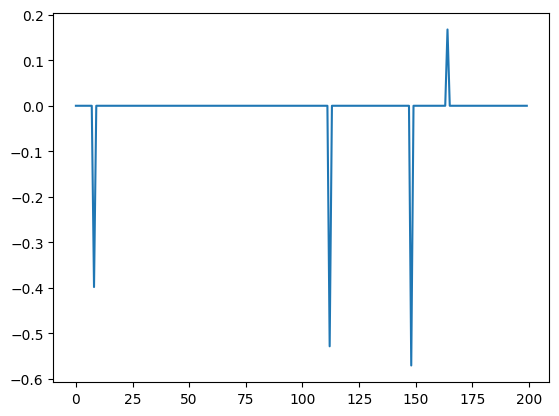

In [5]:
plt.plot(x)

In [6]:
A = np.random.normal(size = (150,200))
A /= np.linalg.norm(A, axis = 0)

eps = np.random.normal(scale=0.01, size = 150)

In [7]:
y = A @ x + eps

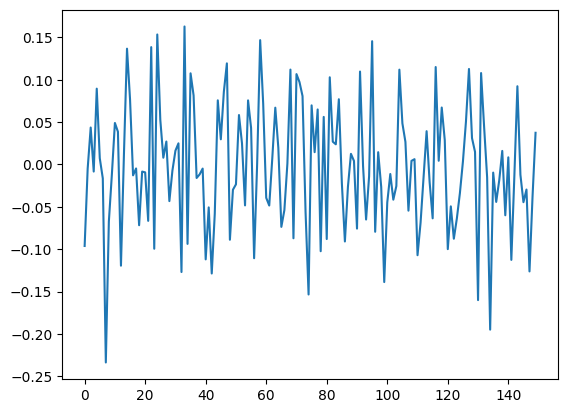

In [8]:
plt.plot(y)

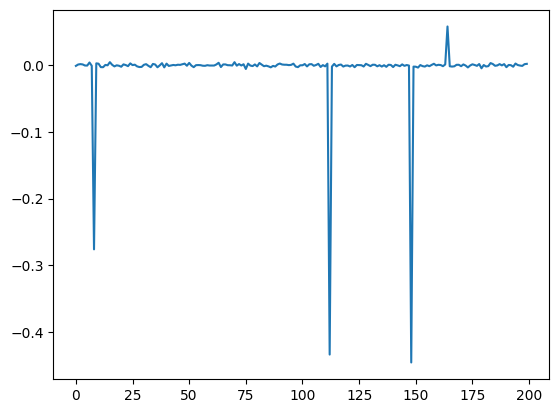

In [9]:
x_hat = ADMM(A, y, max_iter=200)
plt.plot(x_hat)

____________________________________

# DeepUnfolding ADMM 

First of all let's start to work in a Torch framework, defining a dataset $\mathcal{D} = \{(s^i, x^i)\}_{i=1}^N$ where each pair is made of a ground truth signal $s^i \in \mathbb{R}^{300}$ and a underdetermined and noisy representation of $s$ defined as $x = Hs + \epsilon$, being $H$ a normalized gaussian random matrix and $\epsilon$ an IID gaussian noise. 

In [10]:
import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt


SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

In [11]:
class SyntheticSignals():
    def __init__(self, A, n, m, s, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 256):
        
        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset

        self.x = torch.zeros(self.size,self.n)
        self.y = torch.zeros(self.size,self.m)

        self.A = A          # Matrix for the linear observation

        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.s = s          # Sparsity of the signal

        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.m, self.s, replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = self.s)

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i,:] = self.A @ self.x[i,:] + np.random.normal(scale=self.eps_sigma, size=self.m)


    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)

We assume the measurement matrix is shared through all the dataset: we can finally build a ```train_set``` and a ```test_set```. 

In [42]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
s_ = 4

# Measurement matrix
A_ = torch.randn(150,200)
A_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_).set_loader()

test_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_).set_loader()

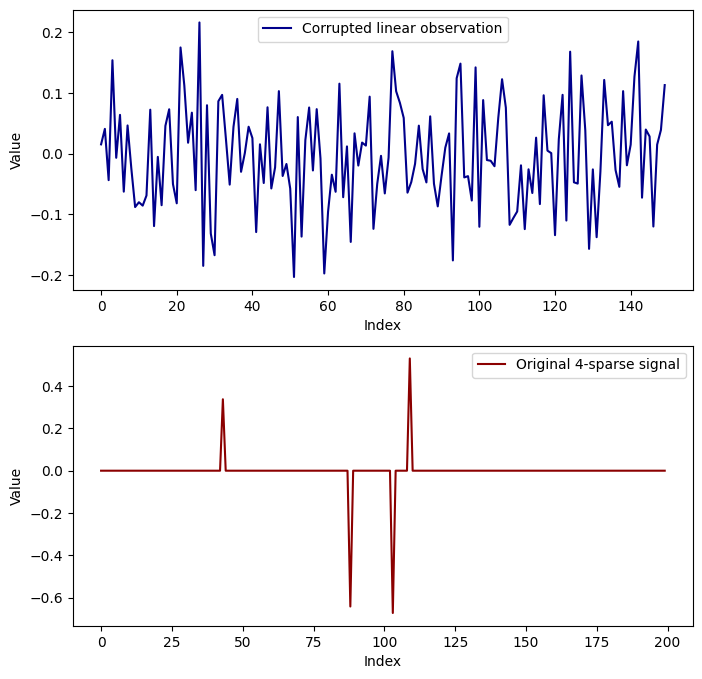

In [43]:
y_ex, x_ex =test_set.dataset.__getitem__(0)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(y_ex, label = 'Corrupted linear observation', color = 'darkblue')
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2)
plt.plot(x_ex, label = 'Original 4-sparse signal', color='darkred')
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

In [44]:
class ADMMLayer(nn.Module):
    def __init__(self, A, rho = 0.01, lambda_ = 0.01, mu = 0.00005):
        super().__init__()

        # Measurement matrix 
        self.A = A

        # Initialization of the learnable parameters
        self.rho = nn.Parameter(torch.ones(1)*rho, requires_grad = True)
        self.lambda_ = nn.Parameter(torch.ones(1)*lambda_, requires_grad = True)
        self.mu = nn.Parameter(torch.ones(1)*mu, requires_grad = True)


    def softshrink(self, x, L):
        return torch.sign(x) * torch.maximum(torch.zeros_like(x), torch.abs(x) - L)
    

    def forward(self, y, z = None, u = None):
        # The forward pass is based on ADMM iteration

        psi = torch.linalg.inv(self.A.T @ self.A + self.rho*torch.eye(self.A.shape[1]))
        
        if z == None and u == None:     
            # Considering batch size
            z = torch.zeros((y.shape[0], self.A.shape[1]))
            u = torch.zeros((y.shape[0], self.A.shape[1]))

        x = (psi @ ((self.A.T @ y.T).T + self.rho * (z - u)).T).T
        z = self.softshrink(x + u, self.lambda_/self.rho)
        u = u + self.mu*(x - z)
        #u = u + (x - z)

        return x, z, u 

In [46]:
class DeepUnfADMM(nn.Module):
    def __init__(self, A, T = 10, rho = 25, lambda_ = 0.01, mu = 0.0005):
        super(DeepUnfADMM, self).__init__()

        # Measurements matrix
        self.A = A

        # Number of iterations <-> number of layers
        self.T = T

        # Initialization of the learnable parameters
        self.rho_0 = torch.ones(T)*rho
        self.lambda_0 = torch.ones(T)*lambda_
        self.mu_0 = torch.ones(T)*mu

        # Defining the layers
        self.ADMM_layers = nn.ModuleList([ADMMLayer(self.A, self.rho_0[i], self.lambda_0[i], self.mu_0[i]) for i in range(self.T)])

    def forward(self, y):
        x, z, u = self.ADMM_layers[0].forward(y)

        for i in range(1,self.T):
            x, z, u = self.ADMM_layers[i].forward(y, z, u)
        
        return x

In [47]:
model = DeepUnfADMM(A_)

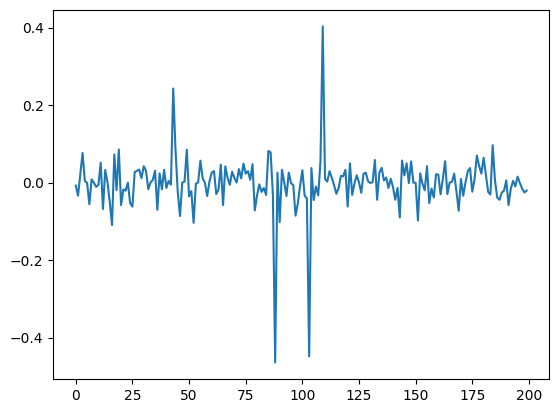

In [48]:
plt.plot(model.forward(y_ex[None,:])[0].detach().numpy())

In [49]:
def train(model, train_loader, valid_loader, num_epochs=50):

    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for _, (b_x, b_s) in enumerate(train_loader):
            s_hat = model(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()

        # Aggregate loss
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for _, (b_x, b_s) in enumerate(valid_loader):
            s_hat = model(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        if epoch % 10 == 0:
            print("Epoch %d, Train loss %.8f, Validation loss %.8f" % (epoch, loss_train[epoch], loss_test[epoch]))

    return loss_test, b_x, b_s

In [50]:
train(model, train_set, test_set)

Epoch 0, Train loss 0.20004753, Validation loss 0.10999307
Epoch 10, Train loss 0.00803680, Validation loss 0.00788523
Epoch 20, Train loss 0.00582105, Validation loss 0.00581038
Epoch 30, Train loss 0.00501675, Validation loss 0.00502372
Epoch 40, Train loss 0.00452311, Validation loss 0.00453826


(array([0.10999307, 0.03702044, 0.01975639, 0.01479143, 0.01258491,
        0.0112404 , 0.01026325, 0.00948871, 0.00885304, 0.00832565,
        0.00788523, 0.00751518, 0.00720298, 0.00693741, 0.00670925,
        0.00651145, 0.00633822, 0.00618489, 0.00604755, 0.00592352,
        0.00581038, 0.00570661, 0.00561047, 0.00552107, 0.00543749,
        0.00535893, 0.00528474, 0.00521451, 0.00514782, 0.00508432,
        0.00502372, 0.00496584, 0.00491039, 0.00485725, 0.00480625,
        0.0047573 , 0.00471016, 0.0046648 , 0.0046211 , 0.00457896,
        0.00453826, 0.00449897, 0.00446105, 0.00442441, 0.00438895,
        0.00435458, 0.00432135, 0.00428913, 0.00425791, 0.00422765]),
 tensor([[-0.0895, -0.0954,  0.0700,  ..., -0.1421, -0.0293,  0.0532],
         [ 0.0149,  0.1741, -0.0088,  ...,  0.1361, -0.1174,  0.1938],
         [ 0.0137, -0.0184,  0.0937,  ...,  0.0116, -0.0639,  0.0735],
         ...,
         [-0.0806, -0.1953, -0.0021,  ..., -0.0216,  0.0326, -0.0183],
         [-0.0146,  

Let's now compare the two approaches when increasing the fixed time horizon: 

Epoch 0, Train loss 0.28588685, Validation loss 0.28745787
Epoch 10, Train loss 0.28531161, Validation loss 0.28663604
Epoch 20, Train loss 0.28529227, Validation loss 0.28663887
Epoch 30, Train loss 0.28528479, Validation loss 0.28663887
Epoch 40, Train loss 0.28528439, Validation loss 0.28663642


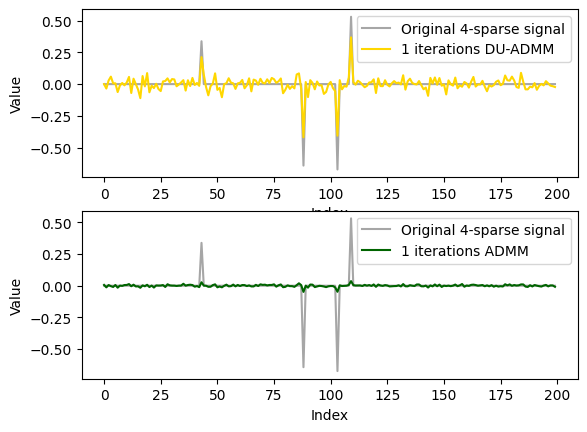

Epoch 0, Train loss 0.26248505, Validation loss 0.21217868
Epoch 10, Train loss 0.05553143, Validation loss 0.05473626
Epoch 20, Train loss 0.03809621, Validation loss 0.03870686
Epoch 30, Train loss 0.03226194, Validation loss 0.03307514
Epoch 40, Train loss 0.02913984, Validation loss 0.03000321


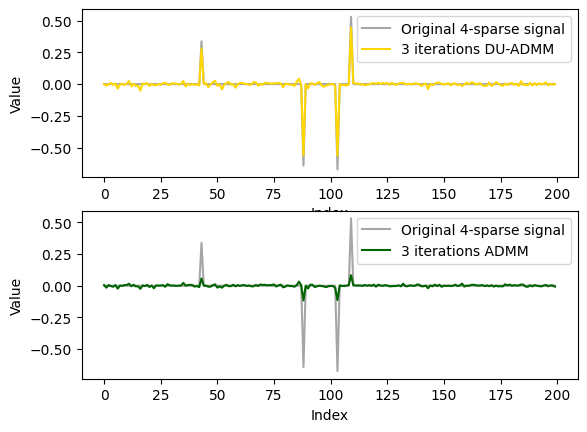

Epoch 0, Train loss 0.24128810, Validation loss 0.16875453
Epoch 10, Train loss 0.01606192, Validation loss 0.01595837
Epoch 20, Train loss 0.01127873, Validation loss 0.01162090
Epoch 30, Train loss 0.01045625, Validation loss 0.01081704
Epoch 40, Train loss 0.01009052, Validation loss 0.01044245


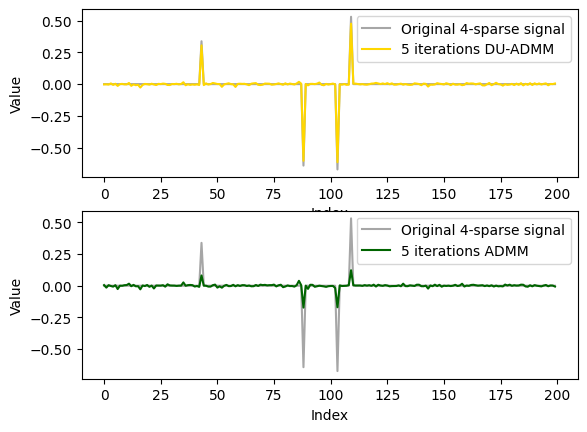

Epoch 0, Train loss 0.22314212, Validation loss 0.13816133
Epoch 10, Train loss 0.00962450, Validation loss 0.00950648
Epoch 20, Train loss 0.00706227, Validation loss 0.00713280
Epoch 30, Train loss 0.00633796, Validation loss 0.00641856
Epoch 40, Train loss 0.00589247, Validation loss 0.00597694


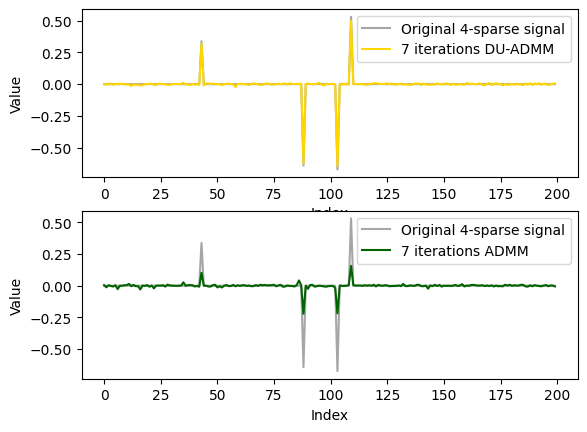

Epoch 0, Train loss 0.20741183, Validation loss 0.11658275
Epoch 10, Train loss 0.00829361, Validation loss 0.00814554
Epoch 20, Train loss 0.00606084, Validation loss 0.00605950
Epoch 30, Train loss 0.00527566, Validation loss 0.00528886
Epoch 40, Train loss 0.00478616, Validation loss 0.00480640


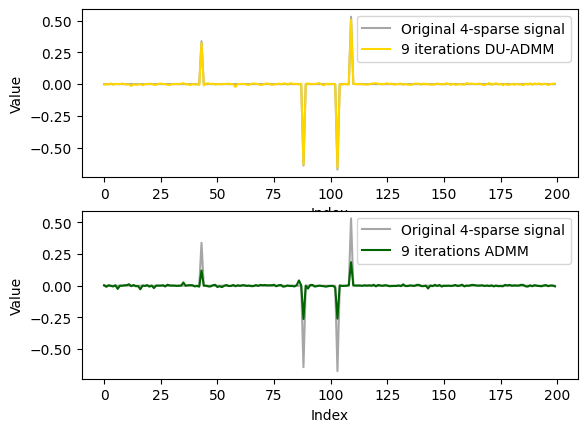

Epoch 0, Train loss 0.19426428, Validation loss 0.10242743
Epoch 10, Train loss 0.00786857, Validation loss 0.00771297
Epoch 20, Train loss 0.00564850, Validation loss 0.00563453
Epoch 30, Train loss 0.00483180, Validation loss 0.00483822
Epoch 40, Train loss 0.00433851, Validation loss 0.00435418


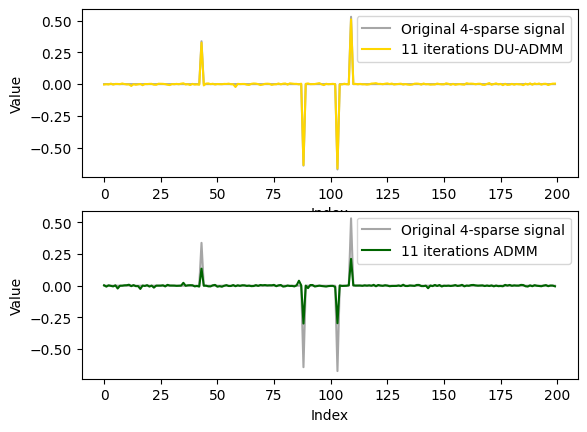

In [61]:
T_ = 13
loss_ADMM = []
loss_DUADMM = []

for T in range (1,T_,2):

    loss_ADMM_ = 0
    for _, (y, x) in enumerate(test_set.dataset):
        x_hat = ADMM(A_.detach().numpy(), y.detach().numpy(), max_iter=T)
        loss_ADMM_ += (np.linalg.norm(x_hat - x.detach().numpy()))**2

    loss_ADMM.append(loss_ADMM_ / len(test_set.dataset))

    model = DeepUnfADMM(A_, T=T)
    loss_DUADMM_, _ , _ = train(model, train_set, test_set)
    loss_DUADMM.append(loss_DUADMM_[-1])

    plt.subplot(2, 1, 1)

    plt.plot(x_ex, label = 'Original 4-sparse signal', color='grey', alpha=0.7)
    plt.plot(model.forward(y_ex[None,:])[0].detach().numpy(), color='gold', label=f'{T} iterations DU-ADMM')

    plt.xlabel('Index', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    plt.legend( )
    plt.subplot (2, 1, 2)

    plt.plot(x_ex, label = 'Original 4-sparse signal', color='grey', alpha=0.7)
    plt.plot(ADMM(A_.detach().numpy(), y_ex.detach().numpy(), max_iter=T), color='darkgreen', 
             label = f'{T} iterations ADMM')
    
    plt.xlabel('Index', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    plt.legend()
    plt.show()

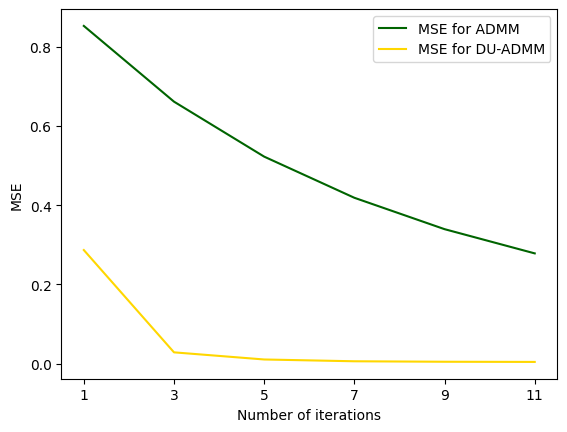

In [62]:
plt.plot(loss_ADMM, label = 'MSE for ADMM', color = 'darkgreen')
plt.plot(loss_DUADMM, label = 'MSE for DU-ADMM', color = 'gold')
plt.xticks([0,1,2,3,4,5],[1,3,5,7,9,11])
plt.xlabel('Number of iterations', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.legend()

In [24]:
model.ADMM_layers[1].mu

Parameter containing:
tensor([-0.4430], requires_grad=True)

___________________________________

# DeepUnfolding ADMM for CS analysis